In [41]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader

In [42]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
#combining multiple transform into one converting numpyarray in a pytorch tensor and then normalizing the data

In [43]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#loading the MNIST data

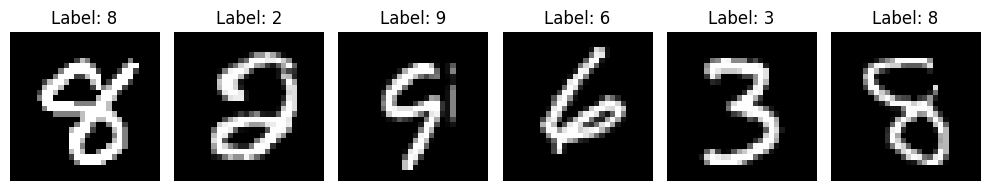

In [44]:
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)

for batch in train_loader:
    images, labels = batch
    break

# Displaying a small batch of images from the dataset along with their corresponding labels.
plt.figure(figsize=(10, 4))
for i in range(6):
    img = images[i][0]
    plt.subplot(1, 6, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title("Label: " + str(labels[i].item()))
    plt.axis('off')
plt.tight_layout()
plt.show()


In [45]:
# Augmentation transform
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# test data untouched
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [46]:
augmented_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(augmented_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [47]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  #output is 32 values with each one 3*3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) #outputs 64 channels
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 digits
        self.dropout = nn.Dropout(0.25) # overfitting prevention

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 14 * 14)# Flatten
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [48]:
model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [49]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()#prev gradient cancelled
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}, Training Loss: {avg_loss:.4f}")

In [50]:
def evaluate(model, device, test_loader, criterion):
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    avg_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return accuracy, avg_loss

In [51]:
for epoch in range(1, 3):  # Train for 5 epochs
    train(model, device, train_loader, optimizer, criterion, epoch)
    evaluate(model, device, test_loader, criterion)

Epoch 1, Training Loss: 0.2372
Test Loss: 0.0485, Accuracy: 98.49%
Epoch 2, Training Loss: 0.0930
Test Loss: 0.0300, Accuracy: 99.08%
Epoch 3, Training Loss: 0.0742
Test Loss: 0.0230, Accuracy: 99.28%
Epoch 4, Training Loss: 0.0623
Test Loss: 0.0259, Accuracy: 99.11%
Epoch 5, Training Loss: 0.0596
Test Loss: 0.0264, Accuracy: 99.11%


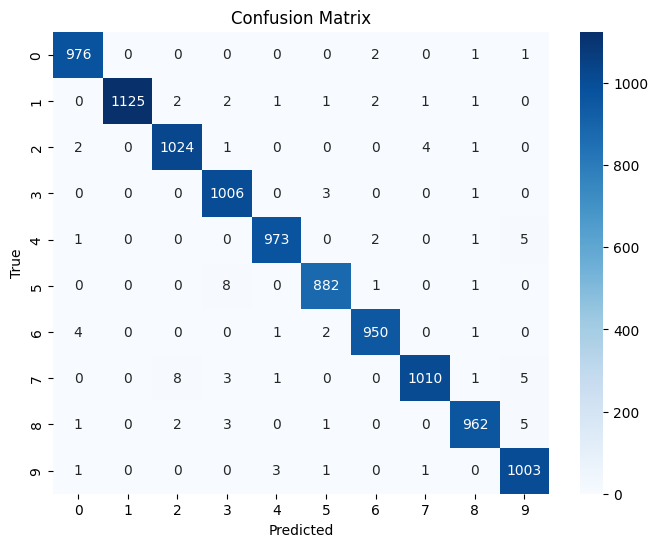

In [52]:
# Get all predictions and true labels
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
